In [24]:
import os
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

In [25]:
#######################################################################################################
#Load saved model
#######################################################################################################
os.chdir(r'I:\DM PROJECT\modelsave')
ts_model=load_model(os.path.join(os.getcwd(), "lstm_anomaly_model.h5"))
ts_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 64)             200960    
                                                                 
 lstm_5 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_6 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 300,097
Trainable params: 300,097
Non-trainable params: 0
_________________________________________________________________


In [26]:
#######################################################################################################
np.random.seed(1)
#Load the sequence data from csv
df = pd.read_csv('I:\DM PROJECT\originaldataset\AEP_hourly.csv')
requests = pd.DataFrame(data=df,columns=['AEP_MW'])
#if any missing value fill it by previous value and convert all requests into integer type
requests.ffill(inplace=True)
requests["AEP_MW"]=requests["AEP_MW"].astype(float).astype(int)
##############################################################################################################
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)

In [27]:
#############################################################################
#scale the data
print("Request Range before scaling:",min(requests.AEP_MW),max(requests.AEP_MW))
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests)
print("Request Range after scaling:",min(scaled_requests),max(scaled_requests))

#Traing data has to be sequential
train_size = int(len(df)*0.99)
test_size =len(df)-train_size

#Number of samples to lookback for each sample
#720 default
lookback =720

#sperate training and test data
train_data = scaled_requests[0:train_size,:]

#Add an additional week for lookback
test_data = scaled_requests[train_size:len(df),:1]

print("\n Shaped of Train ,Test :", train_data.shape ,test_data.shape)


Request Range before scaling: 9581 25695
Request Range after scaling: [-2.28391613] [3.93437215]

 Shaped of Train ,Test : (121151, 1) (122, 1)


In [28]:
#####################################################################################################
#pepare RNN Dataset
def create_rnn_dataset(data, lookback=1):
  
  data_x,data_y = [],[]
  for i in range(len(data)- lookback -1):
    a = data[i:(i + lookback),0]
    data_x.append(a)
    data_y.append(data[i + lookback,0])
  return np.array(data_x),np.array(data_y)

#create x and y for training
x_train , y_train = create_rnn_dataset(train_data , lookback)

#Reshape for use with LSTM
x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))

print("shapes of x,y:",x_train.shape , y_train.shape)
##############################################################################
#Preprocess
x_test , y_test =create_rnn_dataset(test_data , lookback)
x_test = np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))
ts_model.evaluate(x_test , y_test, verbose=1)

#predict for the training dataset
predict_on_train = ts_model.predict(x_train)
#Prdeict on the test dataset
predict_on_test = ts_model.predict(x_test)

#train_mae_loss = np.mean(np.abs(predict_on_train - x_train), axis=1)

shapes of x,y: (120430, 1, 720) (120430,)


IndexError: tuple index out of range

The accuracy of our model is 95.0%
After training the RMSE is:0.2042048099920893
After training the MAE is:[[1.64909939 1.65472258 1.65719324 ... 1.56567951 1.53459289 1.5915003 ]
 [1.65472258 1.65719324 1.69460609 ... 1.53459289 1.5915003  1.63859593]
 [1.65719324 1.69460609 1.7979831  ... 1.5915003  1.63859593 1.70347883]
 ...
 [0.86676096 0.93830592 1.09109251 ... 0.9127276  1.05654009 1.10025289]
 [0.93830592 1.09109251 1.28872568 ... 1.05654009 1.10025289 1.07608601]
 [1.09109251 1.28872568 1.10550954 ... 1.10025289 1.07608601 1.02983168]]


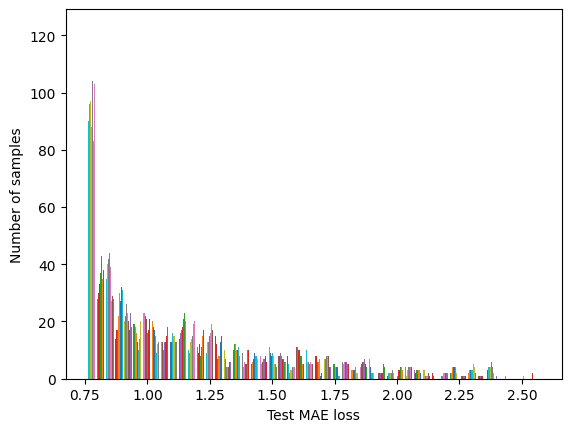

In [ ]:



##########################################################################

from sklearn.metrics import r2_score
score = r2_score(y_test, predict_on_test)
print("The accuracy of our model is {}%".format(round(score, 2) *100))
######################################################################
from sklearn import metrics
import os
score = np.sqrt(metrics.mean_squared_error(y_test,predict_on_test))
print(f'After training the RMSE is:{score}')
#######################################################################
# trainMAE = np.mean(np.abs(predict_on_train - x_train), axis=1)
testMAE = np.mean(np.abs(predict_on_test - x_test), axis=1)
print(f'After training the MAE is:{testMAE}')
#########################################################################
plt.hist(testMAE , bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')
################################################################################

################################################################################
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)
##############################################################################

In [ ]:
# Mean Absolute Error loss
X_train_pred = ts_model.predict(x_train)
train_mae_loss = np.mean(np.abs(X_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)
     

3730/3730 [==============================] - 11s 3ms/step


MemoryError: Unable to allocate 74.6 TiB for an array with shape (119339, 119339, 720) and data type float64